In [1]:
import random
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from seaborn.palettes import color_palette
from sklearn.datasets import load_breast_cancer
import matplotlib.pyplot as plt
import seaborn as sns
import copy
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, RepeatedKFold

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import StackingClassifier

from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

import warnings
warnings.filterwarnings("ignore")

In [4]:
df=pd.read_csv("heart_disease_2015.csv")

In [5]:
df['HeartDiseaseorAttack'].value_counts()

HeartDiseaseorAttack
0.0    229787
1.0     23893
Name: count, dtype: int64

In [6]:
df["HeartDiseaseorAttack"] = df["HeartDiseaseorAttack"].astype('object')

## Undersampling

Divide the datasets based on target variable

In [7]:
negative_df = df[df['HeartDiseaseorAttack'] == 0.0]
positive_df = df[df['HeartDiseaseorAttack'] == 1.0]

Undersample the majority class (negative)

In [8]:
negative_df_undersampled = negative_df.sample(len(positive_df), random_state=8649)

Concatenate new datasets and shuffle

In [9]:
balanced_df = pd.concat([negative_df_undersampled, positive_df])

In [10]:
balanced_df = balanced_df.sample(frac=1, random_state=8649).reset_index(drop=True)

In [11]:
balanced_df['HeartDiseaseorAttack'].value_counts()

HeartDiseaseorAttack
1.0    23893
0.0    23893
Name: count, dtype: int64

Train-test splitting and standardization

In [17]:
x= balanced_df.loc[:,balanced_df.columns != "HeartDiseaseorAttack"]
le = LabelEncoder()
y= le.fit_transform(balanced_df['HeartDiseaseorAttack'])
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=8649)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [18]:
X_train.shape

(38228, 21)

In [19]:
X_test.shape

(9558, 21)

## Modeling

Model training with hyperparameter tuning

In [21]:
# Define the classifiers and parameter space
classifiers = [
    ('Logistic Regression',LogisticRegression(),{
        # 'penalty': ['l1', 'l2'],
        'C': [0.1,0.5,1,3],
        'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
        'max_iter': [100, 200, 500]
    }),
    ('RandomForest', RandomForestClassifier(), {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 20, 40],
    }),
    ('GradientBoosting', GradientBoostingClassifier(), {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.05, 0.1, 0.2, 0.5],
        'max_depth': [2, 3, 5, 8]
    }),
    ('XGBoost', XGBClassifier(), {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.05, 0.1, 0.2],
        'max_depth': [4, 6, 8],
    }),
]

In [22]:
print('-'*20)
for name, clf, param_dist in classifiers:
    print(name)
    print(clf)
    print(param_dist)
    print('-'*20)

--------------------
Logistic Regression
LogisticRegression()
{'C': [0.1, 0.5, 1, 3], 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 'max_iter': [100, 200, 500]}
--------------------
RandomForest
RandomForestClassifier()
{'n_estimators': [50, 100, 200], 'max_depth': [None, 20, 40]}
--------------------
GradientBoosting
GradientBoostingClassifier()
{'n_estimators': [50, 100, 200], 'learning_rate': [0.05, 0.1, 0.2, 0.5], 'max_depth': [2, 3, 5, 8]}
--------------------
XGBoost
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delt

In [24]:
# Store the best models and their accuracy scores
best_models = {}
best_accuracies = []

# Perform GridSearchCV for each classifier
for name, clf, param_dist in classifiers:
    grid_search =GridSearchCV(clf, param_grid=param_dist, cv=9, n_jobs=-1, verbose=2)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    best_models[name] = best_model
    y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    best_accuracies.append((name, accuracy))

Fitting 9 folds for each of 60 candidates, totalling 540 fits
Fitting 9 folds for each of 9 candidates, totalling 81 fits
Fitting 9 folds for each of 48 candidates, totalling 432 fits
Fitting 9 folds for each of 27 candidates, totalling 243 fits


In [25]:
best_models

{'Logistic Regression': LogisticRegression(C=0.1, solver='liblinear'),
 'RandomForest': RandomForestClassifier(max_depth=20, n_estimators=200),
 'GradientBoosting': GradientBoostingClassifier(n_estimators=200),
 'XGBoost': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=0.1, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=4, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=100, n_jobs=None,
               num_parallel_tree=None, random_state=None, ...)}

In [26]:
best_accuracies

[('Logistic Regression', 0.7718141870684243),
 ('RandomForest', 0.7639673571876961),
 ('GradientBoosting', 0.7710818162795564),
 ('XGBoost', 0.7747436702238962)]

In [28]:
y_pred = best_models['XGBoost'].predict(X_test)

In [30]:
# create a dataframe to store the value for both actual values and predictions.
predictions = pd.DataFrame(y_pred, columns=['predictions'])
predictions['actual'] = y_test

# show the classification report
print(classification_report(predictions['actual'], predictions['predictions']))

              precision    recall  f1-score   support

           0       0.81      0.73      0.77      4840
           1       0.75      0.82      0.78      4718

    accuracy                           0.77      9558
   macro avg       0.78      0.78      0.77      9558
weighted avg       0.78      0.77      0.77      9558



Stacked model

In [31]:
# create first level (base) classifier
level0 = list()
level0.append(('Random Forest', RandomForestClassifier(max_depth=20, n_estimators=200)))
level0.append(('Gradient Boosting', GradientBoostingClassifier(n_estimators=200)))
level0.append(('XGBoost Classifier', XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=4)))

# create second level classifier
level1 = LogisticRegression(C=0.1, solver='liblinear')

# apply the stacked classifier based on the first and second level of classifier.
stack_model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
stack_model.fit(X_train, y_train)

StackingClassifier(cv=5,
                   estimators=[('Random Forest',
                                RandomForestClassifier(max_depth=20,
                                                       n_estimators=200)),
                               ('Gradient Boosting',
                                GradientBoostingClassifier(n_estimators=200)),
                               ('XGBoost Classifier',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_roun...
                                              interaction_constraints=None,
                                              learning_rate=0.1, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None, max_depth=4,
                                              max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=100, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=None, ...))],
                   final_estimator=LogisticRegression(C=0.1,
                                                      solver='liblinear'))

## Evaluation

In [32]:
score = stack_model.score(X_test, y_test)
print("Test accuracy score: {0:.2f} %".format(100 * score))
Y_predict = stack_model.predict(X_test)

Test accuracy score: 77.27 %


In [33]:
# create a dataframe to store the value for both actual values and predictions.
predictions = pd.DataFrame(Y_predict, columns=['predictions'])
predictions['actual'] = y_test

# show the classification report
print(classification_report(predictions['actual'], predictions['predictions']))

              precision    recall  f1-score   support

           0       0.80      0.74      0.77      4840
           1       0.75      0.81      0.78      4718

    accuracy                           0.77      9558
   macro avg       0.77      0.77      0.77      9558
weighted avg       0.77      0.77      0.77      9558



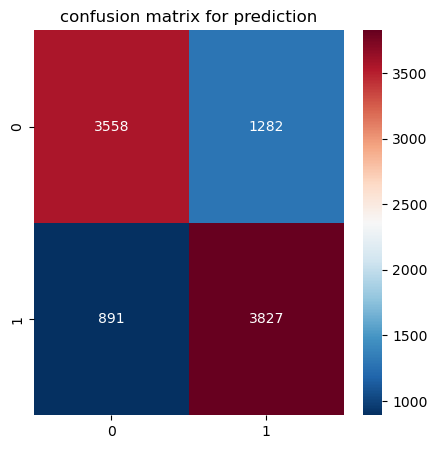

In [34]:
# show the confusion matrix by using the heatmap
cm = confusion_matrix(y_test, Y_predict)
plt.figure(figsize=(5,5),dpi=100)
fig_conf=sns.heatmap(cm, annot=True, fmt='d', cmap='RdBu_r')

# create the title
plt.title('confusion matrix for prediction')

# save the figure
# fig_conf.figure.savefig("confusion_matrix.png")
plt.show()

## Joblib

In [39]:
import joblib
# export the model in a pickle file.
pkl_filename = "StackModelJoblib.joblib"
with open(pkl_filename, 'wb') as file:
    joblib.dump(stack_model, file)

In [40]:
# import the model in the pickle file
with open("StackModelJoblib.joblib", 'rb') as file:
    joblib_model = joblib.load(file)

In [41]:
# check the accuracy of the test set.
score = joblib_model.score(X_test, y_test)
print("Test accuracy score: {0:.2f} %".format(100 * score))
Y_predict = joblib_model.predict(X_test)

Test accuracy score: 77.27 %


## Use smaller sample again

In [12]:
df_small=balanced_df.sample(n=15000, random_state=8649)

In [20]:
x_small= df_small.loc[:,df.columns != "HeartDiseaseorAttack"]
le = LabelEncoder()
y_small= le.fit_transform(df_small['HeartDiseaseorAttack'])
X_train_small, X_test_small, y_train_small, y_test_small = train_test_split(x_small,y_small, test_size=0.2, random_state=8649)
scaler = StandardScaler()
X_train_small = scaler.fit_transform(X_train_small)
X_test_small = scaler.transform(X_test_small)

In [21]:
mean = scaler.mean_
std_dev = scaler.scale_

In [24]:
mean

array([ 0.58133333,  0.55458333,  0.97783333, 28.93708333,  0.51741667,
        0.09983333,  0.48058333,  0.70075   ,  0.61558333,  0.78858333,
        0.04666667,  0.95683333,  0.09366667,  2.89858333,  3.78408333,
        6.52983333,  0.28383333,  0.50258333,  8.99741667,  4.92491667,
        5.65941667])

In [25]:
std_dev

array([ 0.49334054,  0.49701173,  0.14722536,  6.77311781,  0.49969657,
        0.29977765,  0.84159947,  0.45792951,  0.48645708,  0.40831319,
        0.21092389,  0.20323215,  0.29136441,  1.1577124 ,  8.20278184,
       10.62311677,  0.45085693,  0.49999333,  2.89670675,  1.02092074,
        2.16992772])

In [15]:
# create first level (base) classifier
level0 = list()
level0.append(('Random Forest', RandomForestClassifier(max_depth=20, n_estimators=200)))
level0.append(('Gradient Boosting', GradientBoostingClassifier(n_estimators=200)))
level0.append(('XGBoost Classifier', XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=4)))

# create second level classifier
level1 = LogisticRegression(C=0.1, solver='liblinear')

# apply the stacked classifier based on the first and second level of classifier.
stack_model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
stack_model.fit(X_train_small, y_train_small)

StackingClassifier(cv=5,
                   estimators=[('Random Forest',
                                RandomForestClassifier(max_depth=20,
                                                       n_estimators=200)),
                               ('Gradient Boosting',
                                GradientBoostingClassifier(n_estimators=200)),
                               ('XGBoost Classifier',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_roun...
                                              interaction_constraints=None,
                                              learning_rate=0.1, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None, max_depth=4,
                                              max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=100, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=None, ...))],
                   final_estimator=LogisticRegression(C=0.1,
                                                      solver='liblinear'))

In [17]:
score = stack_model.score(X_test_small, y_test_small)
print("Test accuracy score: {0:.2f} %".format(100 * score))
Y_predict = stack_model.predict(X_test_small)

Test accuracy score: 77.53 %


In [35]:
stack_model.predict(np.array(standardized_data_point).reshape(1,21))

array([1])

In [18]:
# create a dataframe to store the value for both actual values and predictions.
predictions = pd.DataFrame(Y_predict, columns=['predictions'])
predictions['actual'] = y_test_small

# show the classification report
print(classification_report(predictions['actual'], predictions['predictions']))

              precision    recall  f1-score   support

           0       0.80      0.75      0.78      1561
           1       0.75      0.80      0.77      1439

    accuracy                           0.78      3000
   macro avg       0.78      0.78      0.78      3000
weighted avg       0.78      0.78      0.78      3000



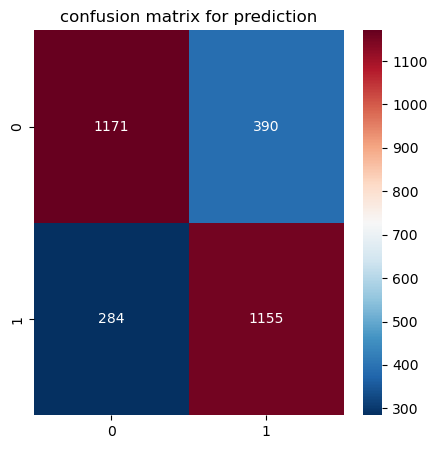

In [19]:
# show the confusion matrix by using the heatmap
cm = confusion_matrix(y_test_small, Y_predict)
plt.figure(figsize=(5,5),dpi=100)
fig_conf=sns.heatmap(cm, annot=True, fmt='d', cmap='RdBu_r')

# create the title
plt.title('confusion matrix for prediction')

# save the figure
# fig_conf.figure.savefig("confusion_matrix.png")
plt.show()

In [51]:
import joblib
# export the model in a pickle file.
pkl_filename = "SmallStackModelJoblib.joblib"
with open(pkl_filename, 'wb') as file:
    joblib.dump(stack_model, file)

In [52]:
# import the model in the pickle file
with open("SmallStackModelJoblib.joblib", 'rb') as file:
    joblib_model = joblib.load(file)

In [53]:
# check the accuracy of the test set.
score = joblib_model.score(X_test, y_test)
print("Test accuracy score: {0:.2f} %".format(100 * score))
Y_predict = joblib_model.predict(X_test)

Test accuracy score: 82.75 %
